In [15]:
import talk.config as con

% matplotlib inline

con.config_mosek()
con.config_configManager()
con.config_matplotlib()

Set MOSEKLM_LICENSE_FILE environment variable
Update ConfigManager


Constructing estimators 
------------------------
https://en.wikipedia.org/wiki/Autoregressive_model

#### Thomas Schmelzer

A very common estimator is based on AR models (autoregressive)

$$R_T = \sum_{i=1}^n w_i r_{T-i}$$

Predict the (unknown) return $R_T$ using the last $n$ previous returns. **Attention**: You may want to use volatility adjusted returns, apply filters etc.
 
How to pick the $n$ free parameters in $\mathbf{w}$? (Partial) autocorrelations? 



In [16]:
def convolution(ts, weights):
    from statsmodels.tsa.filters.filtertools import convolution_filter
    return convolution_filter(ts, weights, nsides=1)

In [17]:
import pandas as pd

r = pd.Series([1.0, -2.0, 1.0, 1.0, 1.5, 0.0, 2.0])
weights = [2.0, 1.0]
# trendfollowing == positive weights
x=pd.DataFrame()
x["r"] = r
x["pred"] = convolution(r, weights)
x["before"] = x["pred"].shift(1)
print(x)
print(x.corr())

     r  pred  before
0  1.0   NaN     NaN
1 -2.0  -3.0     NaN
2  1.0   0.0    -3.0
3  1.0   3.0     0.0
4  1.5   4.0     3.0
5  0.0   1.5     4.0
6  2.0   4.0     1.5
               r      pred    before
r       1.000000  0.895788 -0.190159
pred    0.895788  1.000000  0.538431
before -0.190159  0.538431  1.000000


In [18]:
import pandas as pd

# mean-reversion == negative weights
r = pd.Series([1.0, -2.0, 1.0, 1.0, 1.5, 0.0, 2.0])
weights = [-2.0, -1.0]
x=pd.DataFrame()
x["r"] = r
x["pred"] = convolution(r, weights)
x["before"] = x["pred"].shift(1)
print(x)
print(x.corr())

     r  pred  before
0  1.0   NaN     NaN
1 -2.0   3.0     NaN
2  1.0   0.0     3.0
3  1.0  -3.0     0.0
4  1.5  -4.0    -3.0
5  0.0  -1.5    -4.0
6  2.0  -4.0    -1.5
               r      pred    before
r       1.000000 -0.895788  0.190159
pred   -0.895788  1.000000  0.538431
before  0.190159  0.538431  1.000000


## Looking only at the last two returns might be a bit ...

Is it a good idea to have $n=200$ free parameters?



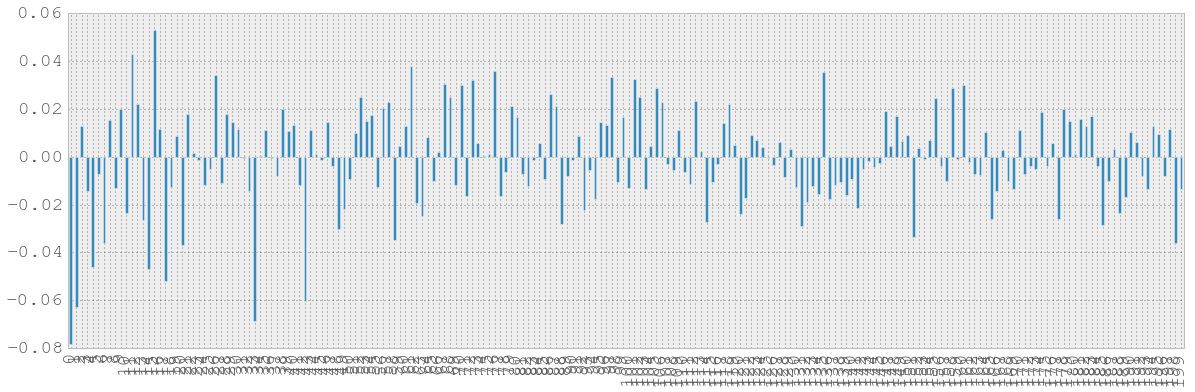

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as sts
# generate random returns
import pandas as pd
r = pd.read_csv("SPX_Index.csv", squeeze=True, index_col=0, parse_dates=True).pct_change().dropna()
# let's compute the optimal convolution!
weights = sts.pacf(r, nlags=200)
pd.Series(data=weights[1:]).plot(kind="bar")
plt.show()

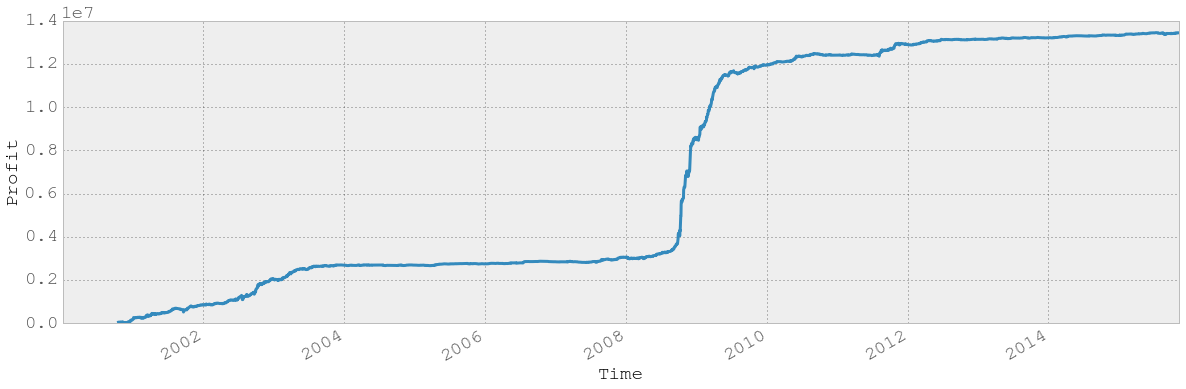

In [20]:
# The trading system! 
pos = convolution(r, weights[1:])
pos = 1e6*(pos/pos.std())
# profit = return[today] * position[yesterday]
(r*pos.shift(1)).cumsum().plot()
plt.xlabel('Time'), plt.ylabel('Profit')
plt.show()

Bias
----

We assume the weights are exponentially decaying, e.g.

$$w_i = \frac{1}{S}\lambda^i$$

where $S$ is a suitable scaling constant and $\lambda = 1-1/N$. Note that $N \neq n$.

**Everything** that is **not** an exponentially weighted moving average is **wrong**.


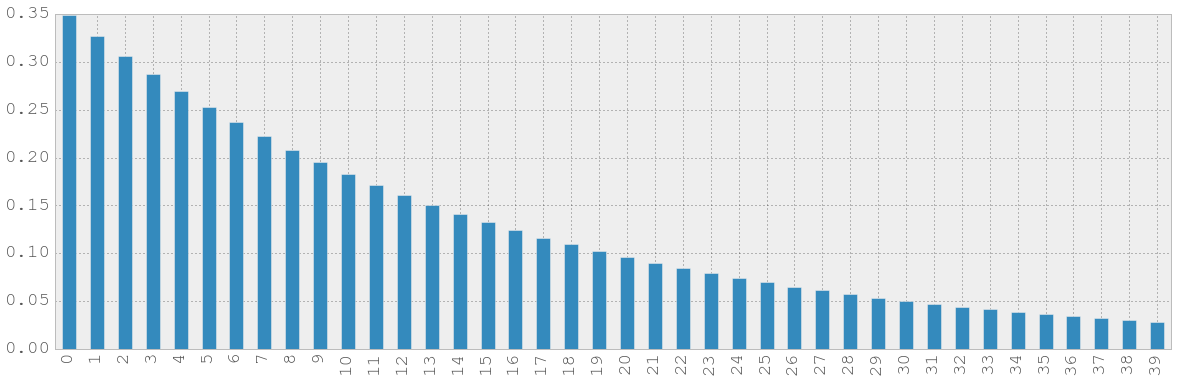

In [21]:
import numpy as np

def exp_weights(m, n=100):
    x = np.power(1.0 - 1.0/m, range(1,n+1))
    S = np.linalg.norm(x)
    return x/S

pd.Series(exp_weights(m=16,n=40)).plot(kind="bar")
plt.show()

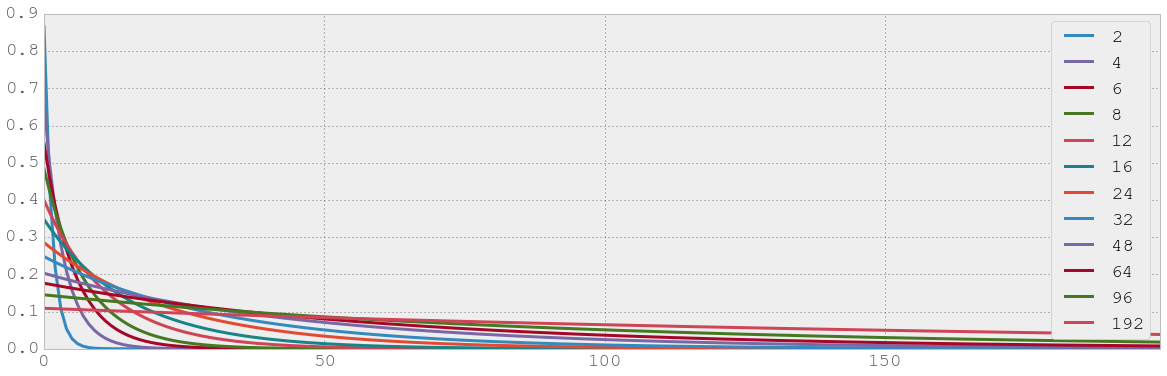

In [22]:
import numpy as np
import pandas as pd

periods = [2,4,6,8,12,16,24,32,48,64,96,192]
# matrix of weights
W = pd.DataFrame({period : exp_weights(m=period, n=200) for period in periods}) 
W.plot()

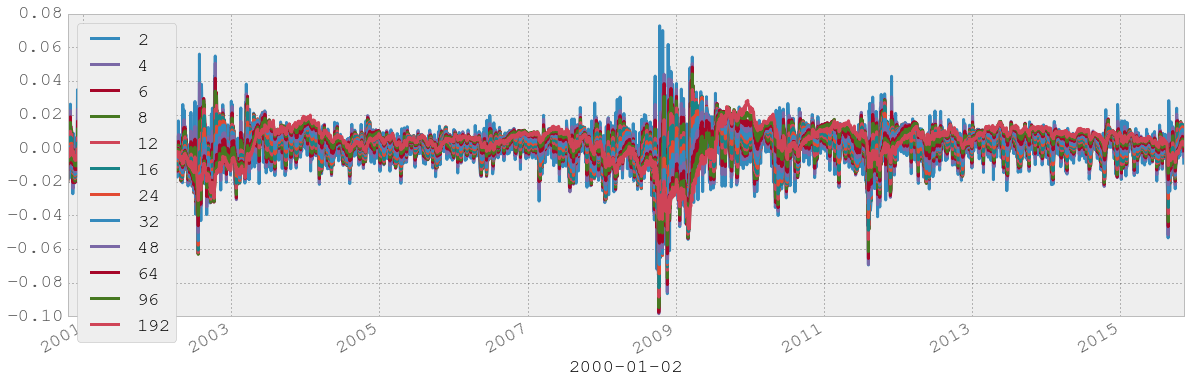

In [23]:
# each column of A is a convoluted return time series
A = pd.DataFrame({period : convolution(r, W[period]).shift(1) for period in periods})  

A = A.dropna(axis=0)
r = r[A.index].dropna()

A.plot()
plt.show()

(Naive) regression
-------------------

\begin{align}
\mathbf{w}^{*}=\arg\min_{\mathbf{w} \in \mathbb{R}^m}& \rVert{\mathbf{A}\mathbf{w} - \mathbf{r}}\lVert_2 
\end{align}

2       -0.483518
4        8.391620
6      -57.972138
8      140.641232
12    -337.078781
16     499.437196
24    -605.732211
32     477.885880
48     -38.231329
64    -217.640726
96     167.438089
192    -36.934243
dtype: float64


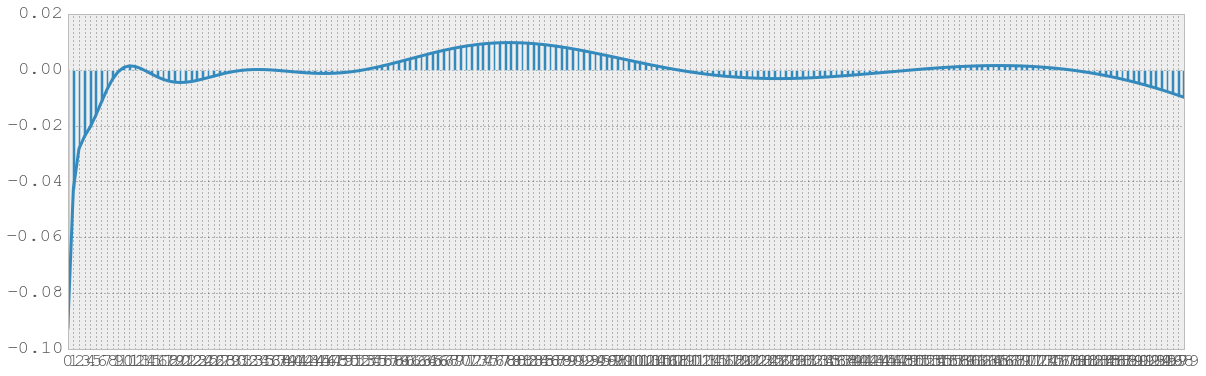

In [24]:
from numpy.linalg import lstsq
# sometimes you don't need to use MOSEK :-)
weights = pd.Series(index=periods, data=lstsq(A.values, r.values)[0])
print(weights)
(W*weights).sum(axis=1).plot(kind="bar")
(W*weights).sum(axis=1).plot()
plt.show()

### Mean variation

We provide a few indicators. Avoid fast indicators. Prefer slower indicators as they induce less trading costs.
Use the mean variation of the signal (convoluted returns here)

$$f(\mathbf{x}) = \frac{1}{n}\sum{\lvert x_i - x_{i-1}\rvert}=\frac{1}{n}\rVert{\Delta \mathbf{x}}\lVert_1$$

The $i$th column of $\mathbf{A}$ has a mean variation $d_i$. We introduce the diagonal penalty matrix $\mathbf{D}$ with $D_{i,i}=d_i$.

$$\mathbf{w}^{*}=\arg\min_{\mathbf{w} \in \mathbb{R}^m} \lVert{\mathbf{Aw}-\mathbf{r}}\rVert_2 + \lambda \rVert{\mathbf{Dw}}\lVert_1$$

In [25]:
def mean_variation(ts):
    return ts.diff().abs().mean()

d = A.apply(mean_variation)
D = np.diag(d)
    
from mosek.fusion import *
# but you could use Mosek: 
def __two_norm(model, v):
    # add variable to model for the 2-norm of the residual
    x = model.variable(1, Domain.greaterThan(0.0))
    # add the quadratic cone
    model.constraint(Expr.vstack(x,v), Domain.inQCone())
    return x


def __one_norm(model, v):
    t = model.variable(int(v.size()), Domain.greaterThan(0.0))
    model.constraint(Expr.hstack(t, v), Domain.inQCone(int(v.size()), 2))
    return Expr.sum(t)


def ar(A, D, r, lamb=0.0):

    with Model('lasso') as model:
        n = int(A.shape[1])
        # introduce the variable for the var
        x = model.variable("x", n, Domain.unbounded())
        # minimization of the conditional value at risk
        a1 = __two_norm(model, Expr.sub(Expr.mul(DenseMatrix(A),x), Expr.constTerm(r)))
        a2 = __one_norm(model, Expr.mul(DenseMatrix(D),x))
        
        model.objective(ObjectiveSense.Minimize, Expr.add(a1, Expr.mul(a2, float(lamb))))
        model.solve()

        return x.level()


2       -0.483496
4        8.388720
6      -57.929959
8      140.475498
12    -336.312898
16     497.597024
24    -600.861177
32     469.931624
48     -27.105627
64    -227.662694
96     171.178761
192    -37.495209
dtype: float64


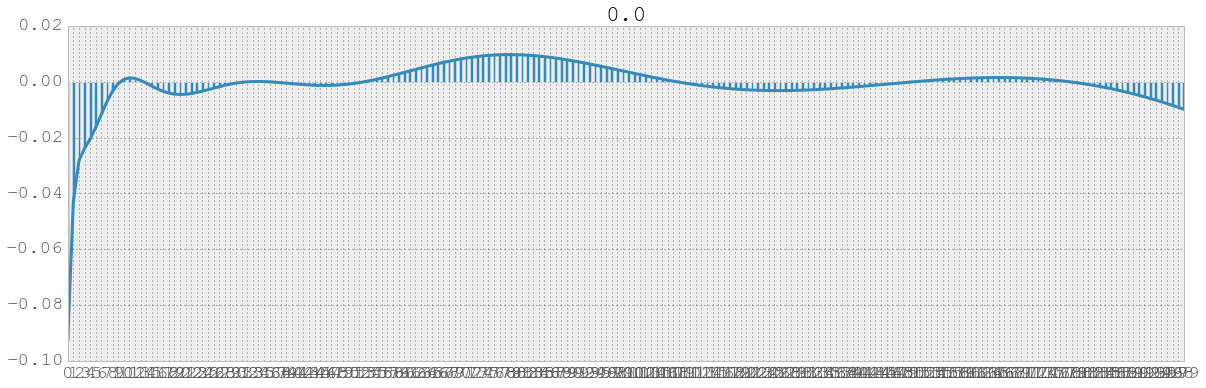

2     -5.131699e-02
4     -3.846480e-02
6     -1.861649e-05
8     -1.040269e-05
12    -1.599525e-05
16    -1.600803e-02
24    -1.389201e-03
32    -1.086154e-05
48    -9.381502e-07
64     2.849865e-06
96     3.191623e-05
192    1.369573e-02
dtype: float64


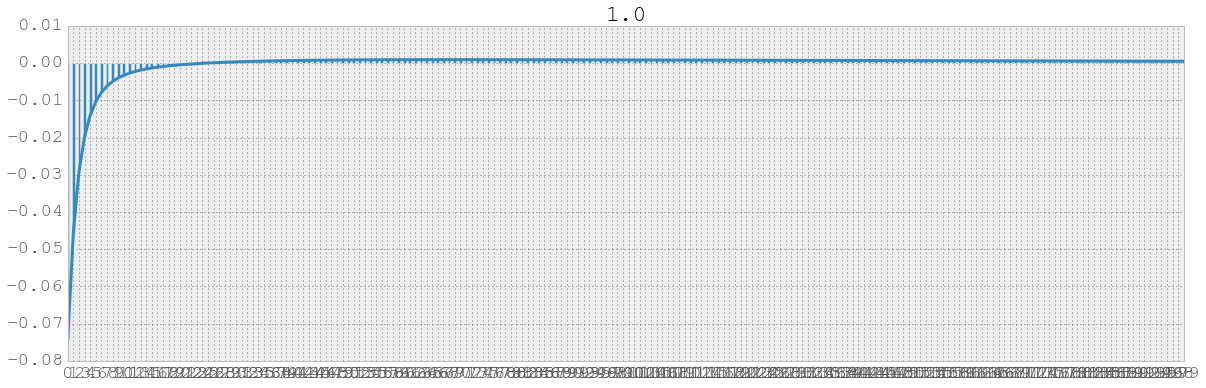

2     -1.676861e-02
4     -6.993185e-02
6     -1.219916e-06
8     -8.523998e-07
12    -1.388775e-06
16    -3.751099e-03
24    -5.910962e-06
32    -6.817471e-07
48    -1.295390e-07
64     2.052771e-08
96     3.138578e-07
192    6.671500e-03
dtype: float64


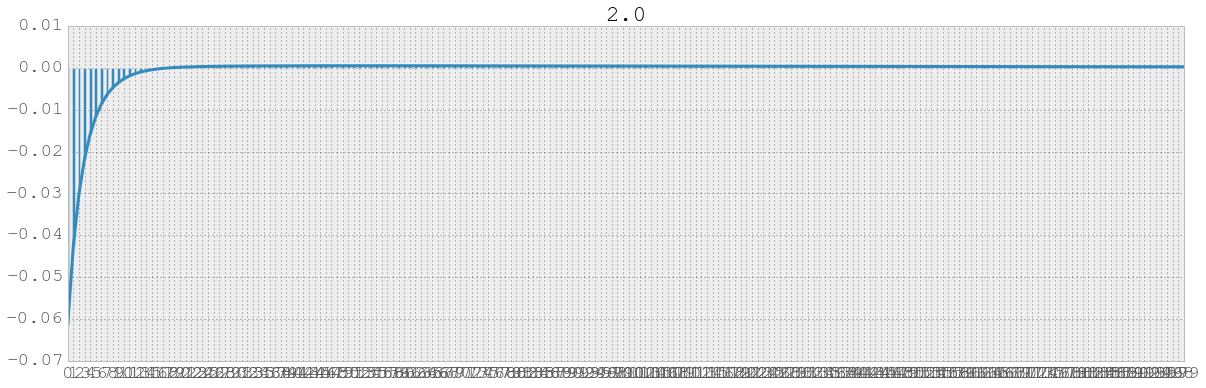

2     -9.807244e-07
4     -7.777539e-02
6     -5.007228e-06
8     -3.037132e-06
12    -4.092486e-06
16    -7.882485e-06
24    -2.097084e-06
32    -7.098982e-07
48    -1.841755e-07
64     1.571413e-08
96     4.188476e-07
192    1.878334e-03
dtype: float64


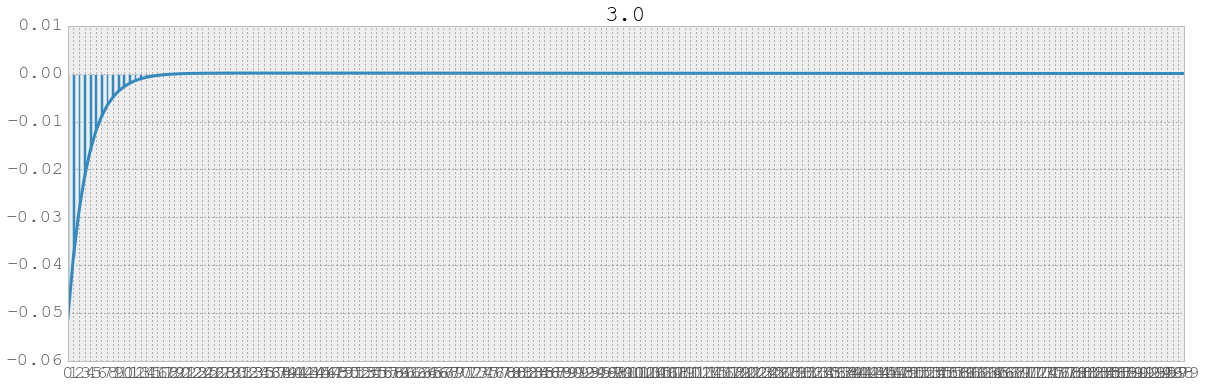

2     -4.738508e-06
4     -1.241728e-02
6     -4.765493e-02
8     -3.805444e-05
12    -2.079127e-05
16    -1.716884e-05
24    -9.855235e-06
32    -5.419502e-06
48    -2.026433e-06
64    -6.455170e-07
96     1.138842e-06
192    4.724233e-06
dtype: float64


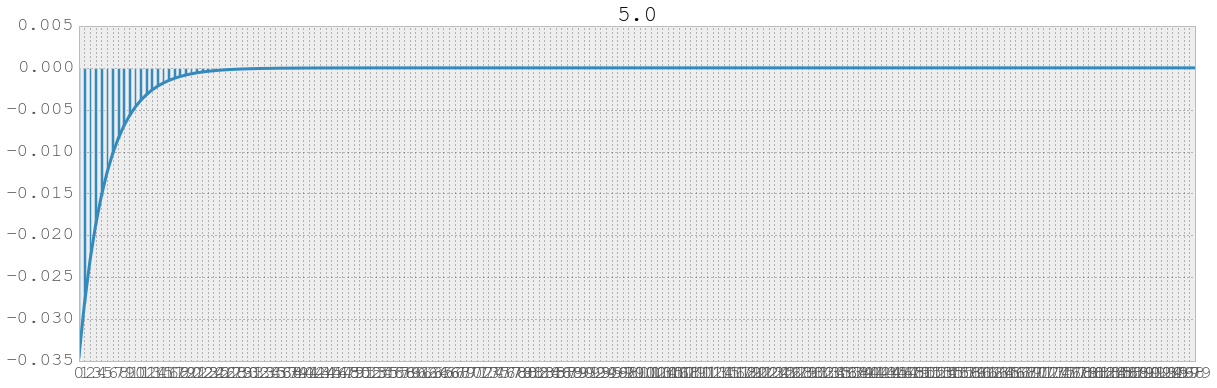

2     -2.642496e-07
4     -1.778909e-06
6     -9.639457e-03
8     -3.487292e-02
12    -7.270657e-06
16    -4.004727e-06
24    -1.688112e-06
32    -8.836005e-07
48    -3.864439e-07
64    -2.231502e-07
96    -8.271335e-08
192    7.513501e-08
dtype: float64


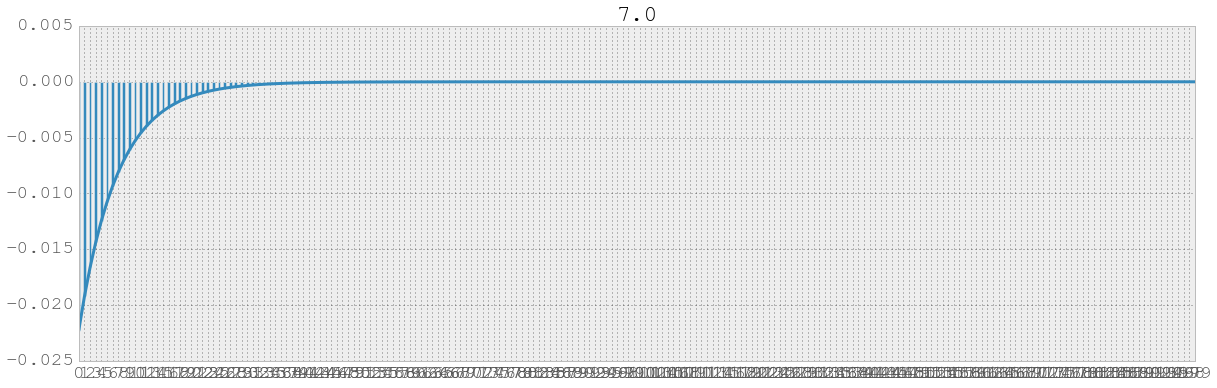

2     -6.660400e-07
4     -4.253270e-06
6     -2.298202e-05
8     -7.036274e-04
12    -3.032837e-02
16    -9.949598e-06
24    -6.675653e-06
32    -3.804368e-06
48    -1.859920e-06
64    -1.202530e-06
96    -6.710545e-07
192   -1.407043e-07
dtype: float64


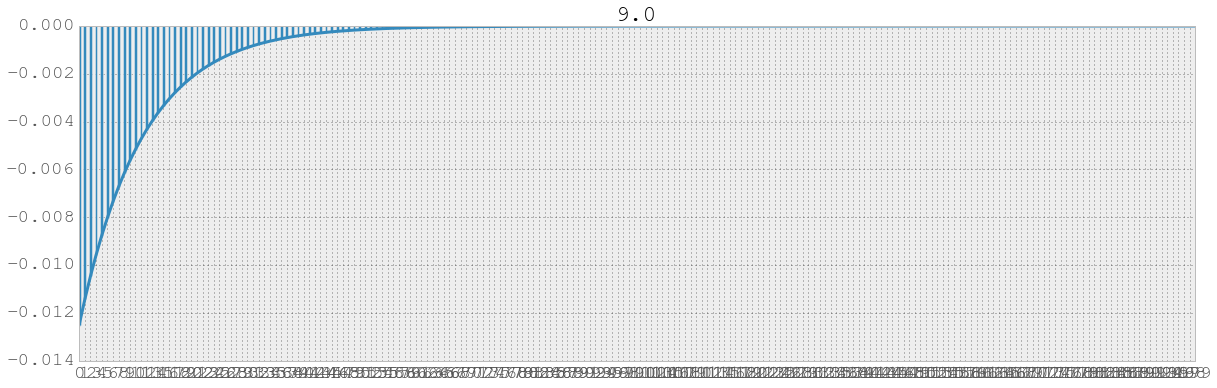

2     -1.845894e-07
4     -6.219852e-07
6     -1.358157e-06
8     -2.508233e-06
12    -5.242247e-06
16    -1.391972e-02
24    -3.406104e-05
32    -6.023433e-06
48    -1.977829e-06
64    -1.216250e-06
96    -7.510774e-07
192   -4.595817e-07
dtype: float64


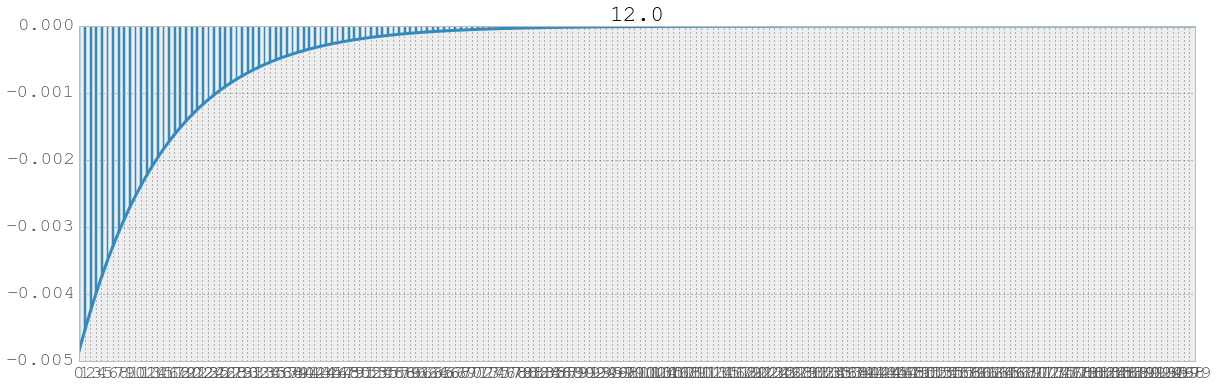

2     -2.542064e-07
4     -7.227623e-07
6     -1.374812e-06
8     -2.251350e-06
12    -5.505969e-06
16    -1.470724e-05
24    -1.110257e-04
32    -5.044495e-05
48    -1.043839e-05
64    -5.814796e-06
96    -3.555937e-06
192   -2.257277e-06
dtype: float64


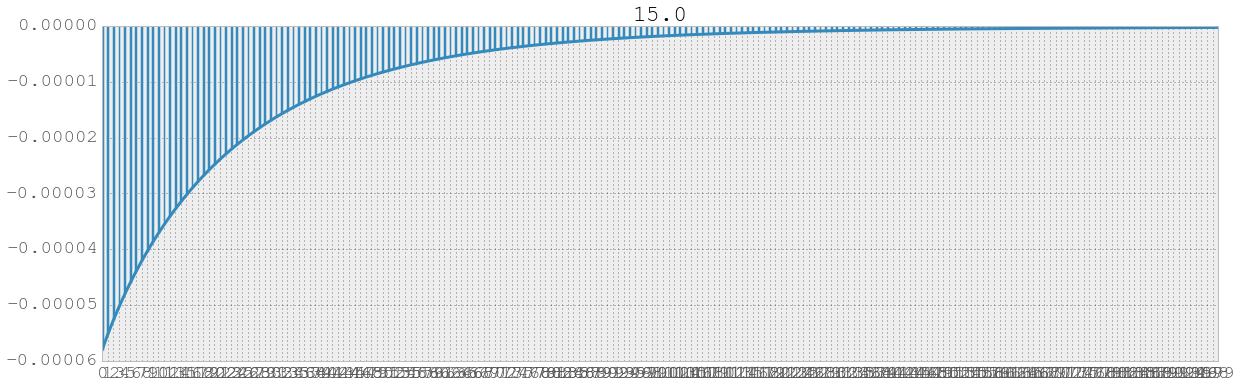

In [26]:
t_weight = dict()
for lamb in [0.0, 1.0, 2.0, 3.0, 5.0, 7.0, 9.0, 12.0, 15.0]:
    weights = pd.Series(index=periods, data=ar(A.values, D, r.values, lamb=lamb))
    print(weights.transpose())
    t_weight[lamb] = (W*weights).sum(axis=1)
    t_weight[lamb].plot(kind="bar")
    t_weight[lamb].plot()
    plt.title(lamb)
    plt.show()

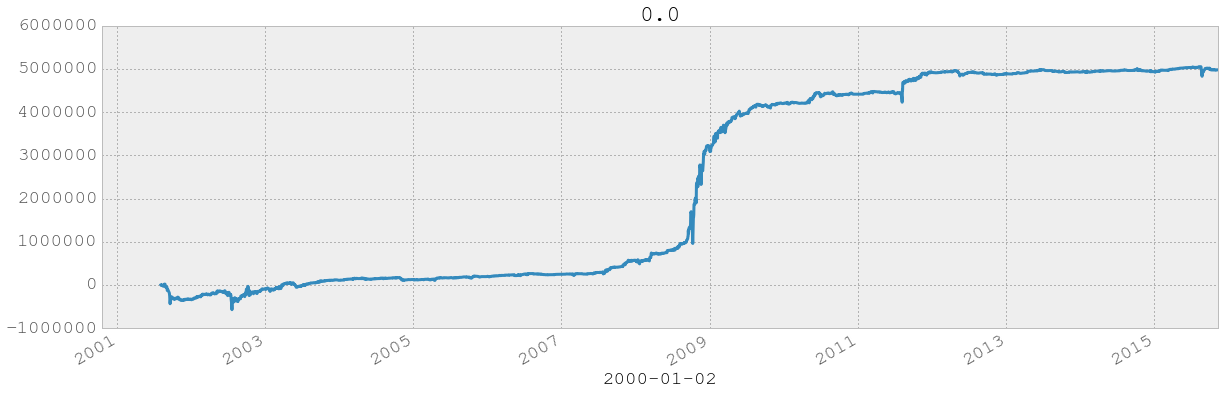

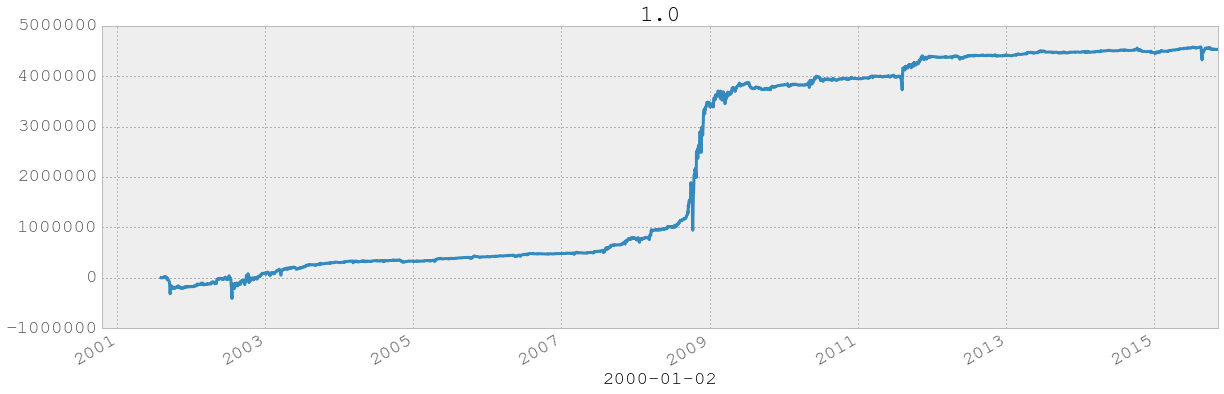

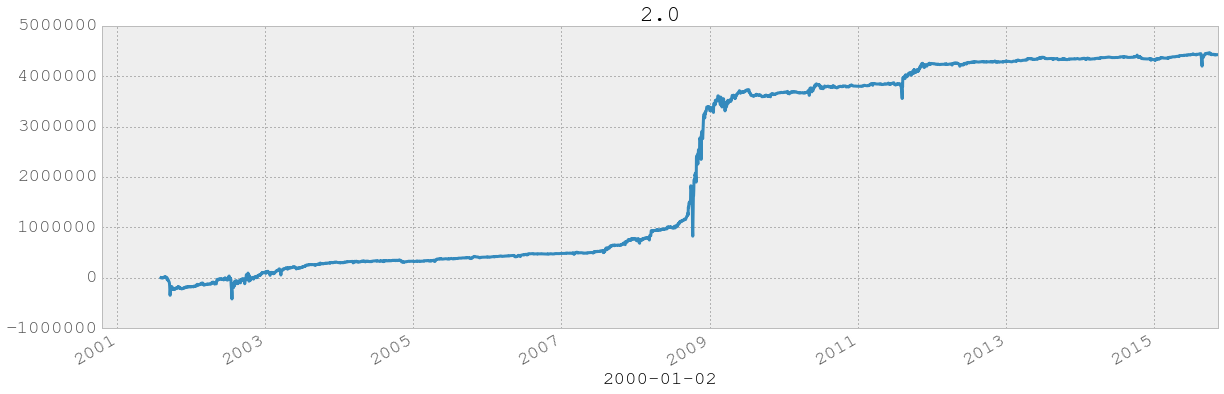

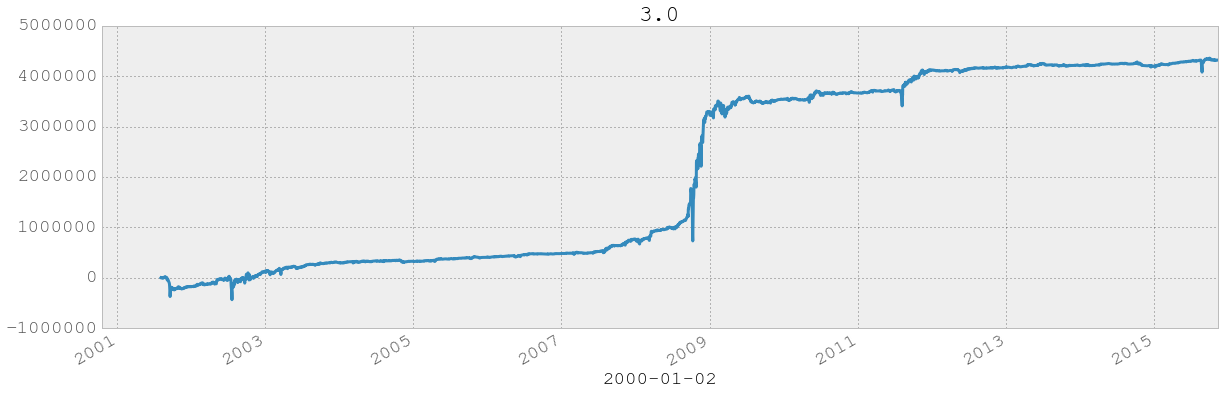

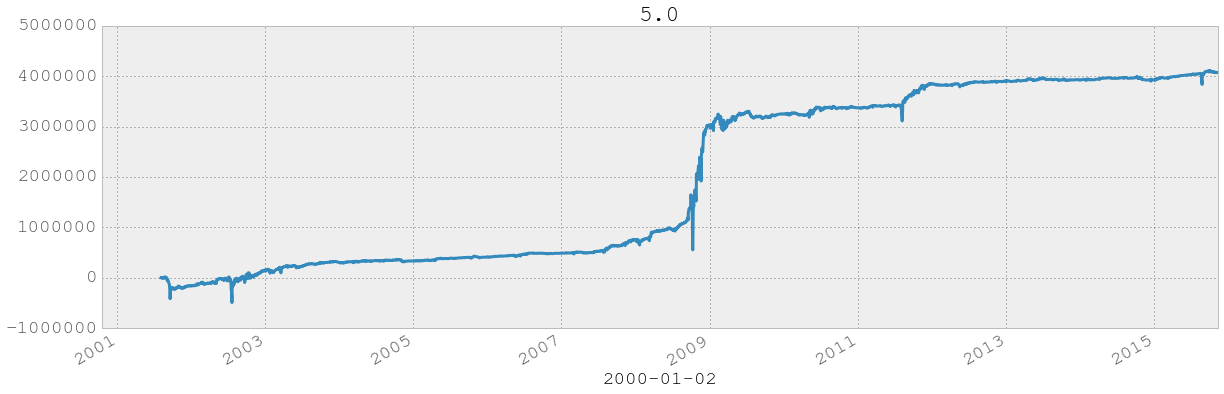

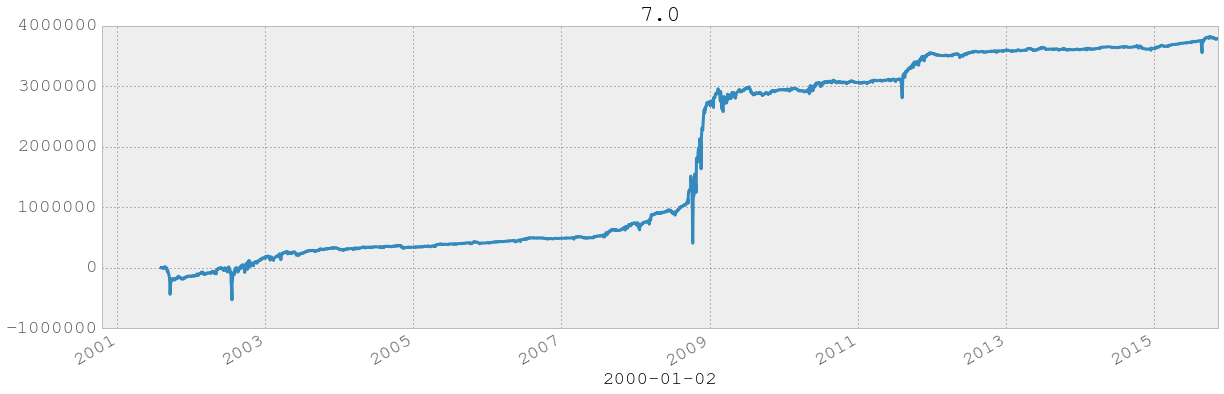

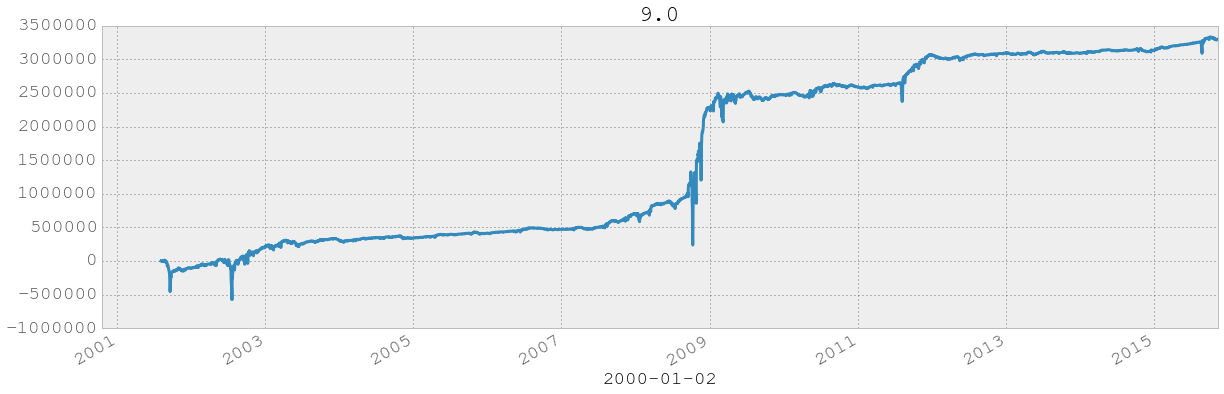

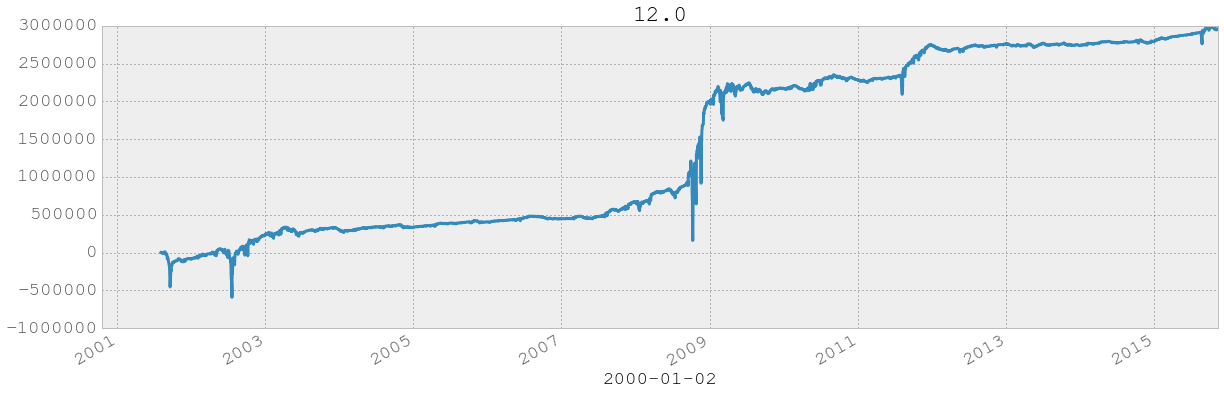

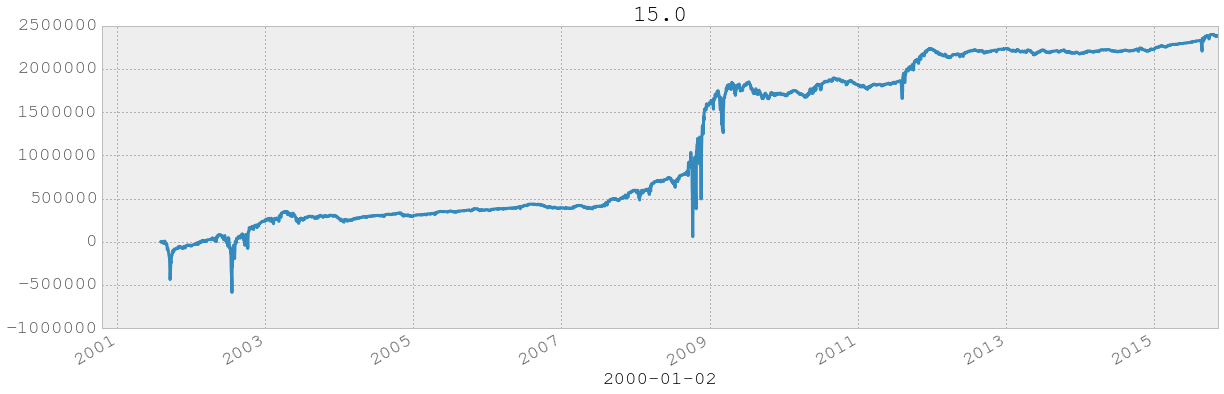

In [27]:
for lamb in sorted(t_weight.keys()):
    pos = convolution(r, t_weight[lamb])
    pos = 1e6*(pos/pos.std())
    (r*pos.shift(1)).cumsum().plot()
    plt.title(lamb)
    plt.show()

In [28]:
d = A.apply(mean_variation)
D = np.diag(d)
weights = pd.Series(index=periods, data=ar(A.values, D, r.values, lamb=3.0))
print(weights)
# let's make the first two moving averages really expensive!

d = A.apply(mean_variation)
D = np.diag(d)
D[0,0] = 100*D[0,0]
D[1,1] = 100*D[1,1]
a = pd.Series(index=periods, data=ar(A.values, D, r.values, lamb=3.0))
print(a)

2     -9.807244e-07
4     -7.777539e-02
6     -5.007228e-06
8     -3.037132e-06
12    -4.092486e-06
16    -7.882485e-06
24    -2.097084e-06
32    -7.098982e-07
48    -1.841755e-07
64     1.571413e-08
96     4.188476e-07
192    1.878334e-03
dtype: float64
2     -3.768222e-12
4     -6.671135e-12
6     -7.929181e-02
8     -3.562460e-07
12    -1.540849e-07
16    -1.269309e-07
24    -9.443772e-08
32    -5.660681e-08
48     4.882971e-09
64     8.199419e-08
96     6.148021e-07
192    7.258373e-03
dtype: float64


### Summary

- The problem of constructing an estimator is corresponds to tracking an index. The index is here a historic return time series. The **assets** are standard estimators. 


- Using the (mean) total variation of the signals can help to prefer slower signals rather than expensive fast signals.


- Using a penalty induced by the $1$-norm (see LARS, LASSO) it is possible to establish a ranking amongst the indicators and construct them robustly. 


- It is possible to (vertical) stack the resulting systems to find optimal weights across a group of assets.

<a href=http://localhost:8888>Back to Overview</a>